In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
#Store our passenger Id for easy access
passengerId=test['PassengerId']

In [3]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


### Outliers Detection

Outliers detection is very important part of feature engineering because ouliers cause our models to not perform much effective as it can be. By removing outlier we can decrease skewness of our data set 

In [5]:
def outlier_detection(df , n , features):
    outlier_index = []
    
    for column in features:
        # 1st quartile(lower) range
        Q1=np.percentile(df[column],25)
        
        #2nd quartile(Upper) range
        
        Q3=np.percentile(df[column],75)
        
        #Interquartile range
        IQR = Q3 - Q1
        
        #Outlier Step
        outlier_step = 1.5 * IQR
        
        no_of_outliers_each_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outlier_index.extend(no_of_outliers_each_column)
    
    outlier_index = Counter(outlier_index)
    multiple_outliers = list(k for k, v in outlier_index.items() if v > 2)
    return multiple_outliers  

In [6]:
Outliers_to_drop=outlier_detection(train,2,["Age","SibSp","Parch","Fare"])

In [7]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [8]:
#Drop Outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [9]:
Outliers_to_drop_test=outlier_detection(test,2,["Age","SibSp","Parch","Fare"])

In [10]:
test.loc[Outliers_to_drop_test]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### Featur Engineering 

Feature Engineering is the most important piller to make good prediction. We will try to fetch out information from our categorical features

In [11]:
full_data=[train , test]
# We will make new column called name_length from name column.
train['name_length'] = train['Name'].apply(len)
test['name_length'] = test['Name'].apply(len)

# we will create new column 'has_cabin' and we code people with cabin to 1 otherwise 0.
train['has_cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['has_cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
 
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature 'isAlone' from newly created feature familySize

for dataset in full_data:
    dataset['isAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1 , 'isAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [33]:
#type(train['Cabin'].loc[1])

str

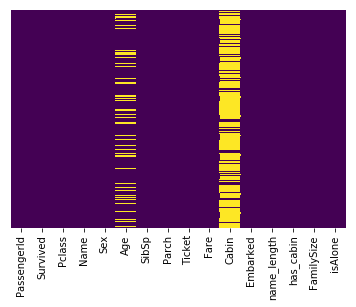

In [12]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Still we have to deal with two null containing columns

### Age
 we will try to fill null values in Age features by taking random int values between (Avg. Age - Std. Age) to (Avg. Age + Std. Age)

In [13]:
for dataset in full_data:
    avg_age = dataset['Age'].mean()
    std_age = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(avg_age-std_age , avg_age+std_age , size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 14, 'Age'] 						          = 0
    dataset.loc[(dataset['Age'] > 14) & (dataset['Age'] <= 30), 'Age']        = 1
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age']        = 2
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age']        = 3
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age']        = 4
    dataset.loc[ dataset['Age'] > 60, 'Age'] 							      = 5

train['Age'].value_counts()

1    422
2    220
3     97
0     78
4     42
5     22
Name: Age, dtype: int64

In [14]:
# Extract title from the name by defining pattern function

def get_title(name):
    title_search = re.search(' ([A-Z,a-z]+)\.' , name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

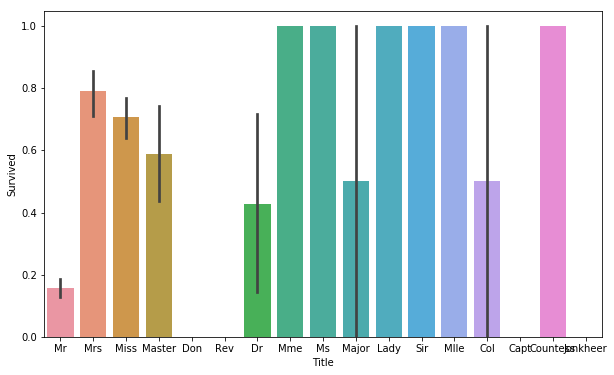

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(x='Title' , y='Survived' , data=train)

Now we can see that there are similer kind of titles so, better we can make them as one group.

In [16]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Mrs','Miss'] , 'MM')
    dataset['Title'] = dataset['Title'].replace(['Dr', 'Major', 'Col'] , 'DMC')
    dataset['Title'] = dataset['Title'].replace(['Don', 'Rev', 'Capt', 'Jonkheer'] , 'DRCJ')
    dataset['Title'] = dataset['Title'].replace(['Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'Countess'] , 'MMLSMC')
    #mapping titles with labls
    title_mapping= {"MM": 1, "Master":2, "Mr": 5, "DMC": 4, "DRCJ": 3, "MMLSMC": 0}
    dataset['Title']=dataset['Title'].map(title_mapping)
    dataset['Title']=dataset['Title'].fillna(3)
    dataset['Title']=dataset['Title'].astype(int)

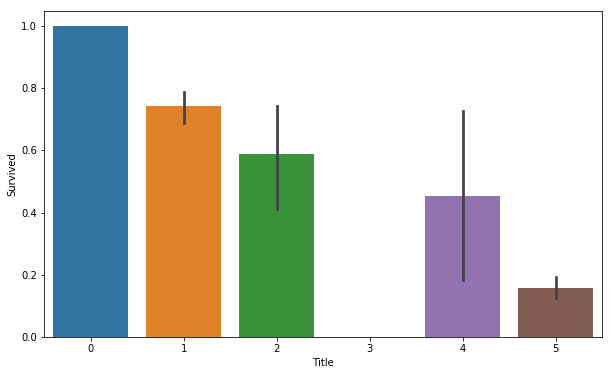

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(x='Title' , y='Survived' , data=train)

In [18]:
#Map Female to 0 and Male to 1
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [19]:
for dataset in full_data:
# Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [20]:
#Mapping Fare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
train['Fare'].value_counts()

2    229
0    223
1    217
3    212
Name: Fare, dtype: int64

In [21]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

All right so now we have cleaned the features and extracted relevant information from categorical features and dropped the categorical columns.

### Visualisations

In [22]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,name_length,has_cabin,FamilySize,isAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,5
1,1,1,0,2,0,3,1,51,1,2,0,1
2,1,3,0,1,0,1,0,22,0,1,1,1
3,1,1,0,2,0,3,0,44,1,2,0,1
4,0,3,1,2,0,1,0,24,0,1,1,5


In [23]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,name_length,has_cabin,FamilySize,isAlone,Title
0,3,1,2,0,0,2,16,0,1,1,5
1,3,0,3,0,0,0,32,0,2,0,1
2,2,1,5,0,1,2,25,0,1,1,5
3,3,1,1,0,1,0,16,0,1,1,5
4,3,0,1,1,1,0,44,0,3,0,1


### Let's plot Pearson correlation heatmap

Let's check relation of each feature to the next feature

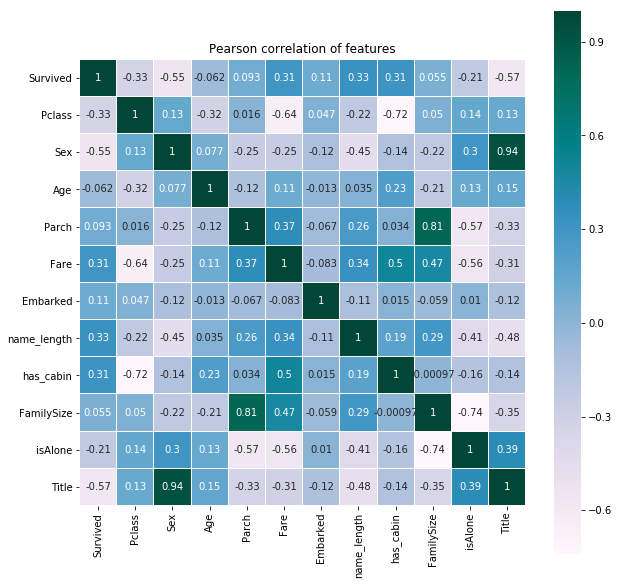

In [24]:
plt.figure(figsize=(10,10))
plt.title('Pearson correlation of features')
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='PuBuGn', linecolor='white', annot=True)

### Conclusion of plot
One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information

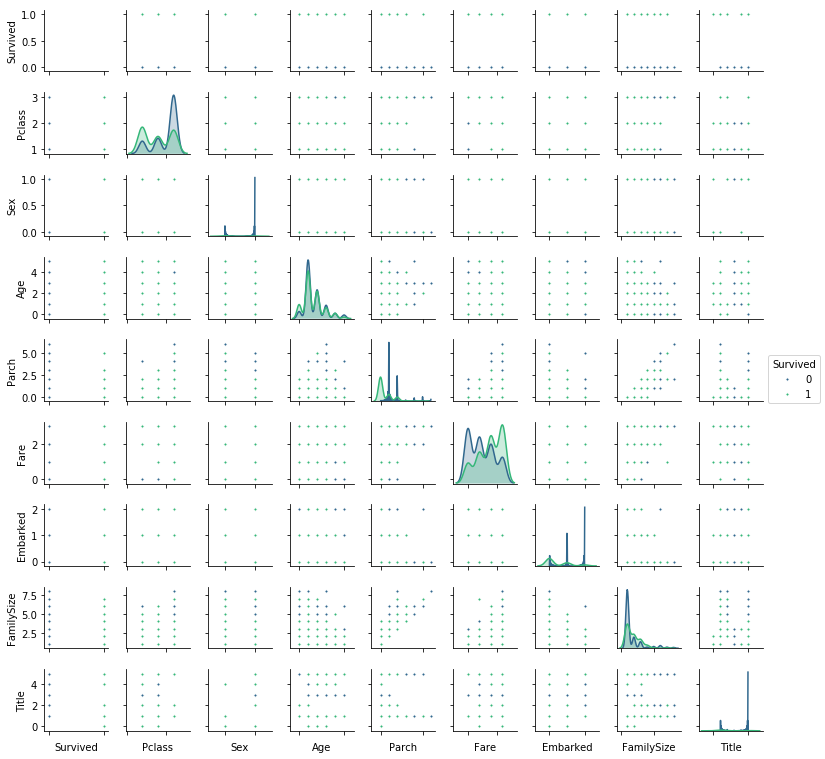

In [26]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'viridis',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

Now data cleaning and feature engineering have done, Let's move to apply Machine learning models to the dataset and see how well it is performing.

In [44]:
# define training and testing sets
X=train.drop('Survived',axis=1)
y=train['Survived']

In [45]:
## Logistic Regression
logmodel=LogisticRegression()

In [46]:
logmodel.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
prediction=logmodel.predict(test)

In [48]:
y_test=pd.read_csv('submission.csv')

In [49]:
y_test=y_test.drop('PassengerId',axis=1)

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
print(accuracy_score(y_test,prediction))

0.9354066985645934


In [52]:
from sklearn.svm import SVC

In [53]:
## Support Vector Machines
svm_model=SVC()

In [54]:
svm_model.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
pred_svc=svm_model.predict(test)

In [56]:
print(accuracy_score(y_test,pred_svc))

0.9066985645933014


So Logistic regression is performing better than the SVM in this case !

### Thanks !!